In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random 
import cv2

import os
from keras.models import Sequential ,Model
from keras.layers import Dense , Dropout , Flatten , MaxPool2D , Conv2D ,Input , BatchNormalization , SeparableConv2D \
 , Activation 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau , EarlyStopping
from keras import backend as BK
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU 
from tensorflow.keras.utils import plot_model

In [2]:
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: c:\Users\nadon\Documents\MSC\UOP\Disser\MI


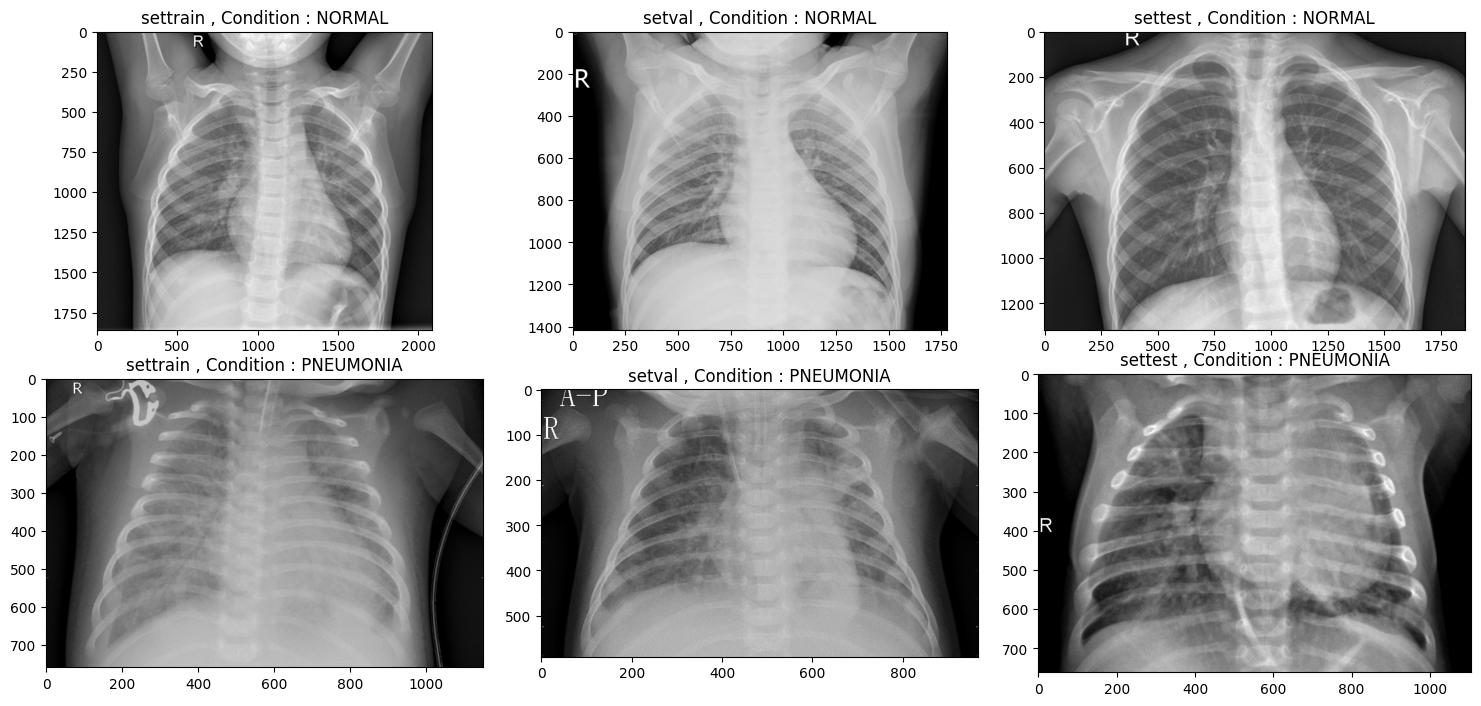

In [3]:
input_path = 'chest_xray/'
fig, ax = plt.subplots(2, 3, figsize=(15, 7))  # Correct usage
ax = ax.ravel()  # Flatten the axes array
plt.tight_layout()
for i ,_set in enumerate(['train' , 'val' , 'test']):
    set_path = input_path + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/' + os.listdir(set_path+'/NORMAL/')[0]),cmap = 'gray' )
    ax[i].set_title('set{} , Condition : NORMAL'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/' + os.listdir(set_path+'/PNEUMONIA/')[0]),cmap = 'gray' )
    ax[i+3].set_title('set{} , Condition : PNEUMONIA'.format(_set))
plt.show()

In [4]:
def process_data(img_dim, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train',
        target_size=(img_dim, img_dim),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    test_gen = test_val_datagen.flow_from_directory(
        directory=input_path+'test',
        target_size=(img_dim, img_dim),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )
    test_data = []
    test_lables = []
    for cond in ['/NORMAL/' , '/PNEUMONIA/']:
        for img in (os.listdir(input_path+'test'+cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img , (img_dims , img_dims))
            img = np.dstack([img , img ,img])
            img = img.astype('float32') /255
            if cond == '/NORMAL/':
                label = 0 
            else: 
                label = 1
            test_data.append(img)
            test_lables.append(label)
        
    test_data = np.array(test_data)
    test_lables.append(test_lables)
    return train_gen , test_gen , test_data , test_lables

In [5]:
img_dims = 150
epochs = 10
batch_size  = 32

train_gen , test_gen , test_data , test_lables = process_data( img_dims , batch_size )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
inputs = Input(shape =( img_dims , img_dims  , 3))
               
# first block
X = Conv2D( filters = 16  ,kernel_size=(3,3) , activation = 'relu' , padding = 'same')(inputs)
X = Conv2D( filters = 16  ,kernel_size=(3,3) , activation = 'relu' , padding = 'same')(X)
X = MaxPool2D(pool_size = (2,2))(X)

# Second block
X = SeparableConv2D( filters = 32  ,kernel_size=(3,3) , activation = 'relu' , padding = 'same')(X)
X = BatchNormalization()(X)
X = MaxPool2D(pool_size = (2,2))(X)

# Third block
X = SeparableConv2D( filters = 32  ,kernel_size=(3,3) , activation = 'relu' , padding = 'same')(X)
X = BatchNormalization()(X)
X = MaxPool2D(pool_size = (2,2))(X)

# fourth block
X = SeparableConv2D( filters = 128  ,kernel_size=(3,3) , activation = 'relu' , padding = 'same')(X)
X = BatchNormalization()(X)
X = MaxPool2D(pool_size = (2,2))(X)
X = Dropout(rate = 0.2)(X)

# Fifth block
X = SeparableConv2D( filters = 256  ,kernel_size=(3,3) , activation = 'relu' , padding = 'same')(X)
X = BatchNormalization()(X)
X = MaxPool2D(pool_size = (2,2))(X)
X = Dropout(rate = 0.2)(X)

# Sixth block
X = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(X)
X = BatchNormalization()(X)
X = MaxPool2D(pool_size=(2, 2))(X)
X = Dropout(rate=0.2)(X)


X = Flatten()(X)
X = Dense(units = 512 , activation = 'relu')(X)
X = Dropout(rate = 0.7)(X)
X = Dense(units = 128 , activation = 'relu')(X)
X = Dropout(rate = 0.5)(X)
X = Dense(units = 64 , activation = 'relu')(X)
X = Dropout(rate = 0.3)(X)

In [7]:
out_put_layer = Dense(units  =1  ,activation = 'sigmoid')(X)

model = Model(inputs = inputs , outputs = out_put_layer)
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics= ['accuracy'])

In [8]:
checkpoint = ModelCheckpoint(filepath = 'best_weights.hdf5' , save_best_only = True , save_weights_only = True)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss'  , factor=0.3  ,patience = 2 , verbose = 2  ,mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss'  , min_delta=0.1  ,patience = 1 , mode = 'min')

In [9]:
hist = model.fit_generator(
        train_gen , steps_per_epoch = train_gen.samples //batch_size
     , epochs = 10 , validation_data = test_gen , 
    validation_steps = test_gen.samples //batch_size , callbacks = [checkpoint , lr_reduce]
)

C:\Users\nadon\AppData\Local\Temp\ipykernel_9024\1102574883.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
163/163 [==============================] - 158s 952ms/step - loss: 0.7058 - accuracy: 0.7726 - val_loss: 0.7851 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 146s 898ms/step - loss: 0.3607 - accuracy: 0.8345 - val_loss: 1.5160 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 159s 976ms/step - loss: 0.3203 - accuracy: 0.8585 - val_loss: 2.8051 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 123s 756ms/step - loss: 0.3016 - accuracy: 0.8748 - val_loss: 1.0473 - val_accuracy: 0.6349 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.8846
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 130s 798ms/step - loss: 0.2751 - accuracy: 0.8846 - val_loss: 0.6219 - val_accuracy: 0.5855 - lr: 0.0010
Epoch 6/10
163/163 [========================

In [10]:
preds = model.predict(test_data)

20/20 [==============================] - 2s 91ms/step


In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

# Assuming test_labels and preds are numpy arrays
acc = accuracy_score(test_lables[0:-1], np.round(preds)) *100
cm = confusion_matrix(test_lables[0:-1], np.round(preds))
tn, fp, fn, tp = cm.ravel()

# Calculate F1 score
f1 = f1_score(test_lables[0:-1], np.round(preds))

# Generate classification report
report = classification_report(test_lables[0:-1], np.round(preds))

print("Accuracy: {:.2f}%".format(acc))
print("F1 Score:", f1)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

Accuracy: 89.90%
F1 Score: 0.9217391304347825
Confusion Matrix:
[[190  44]
 [ 19 371]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       234
           1       0.89      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



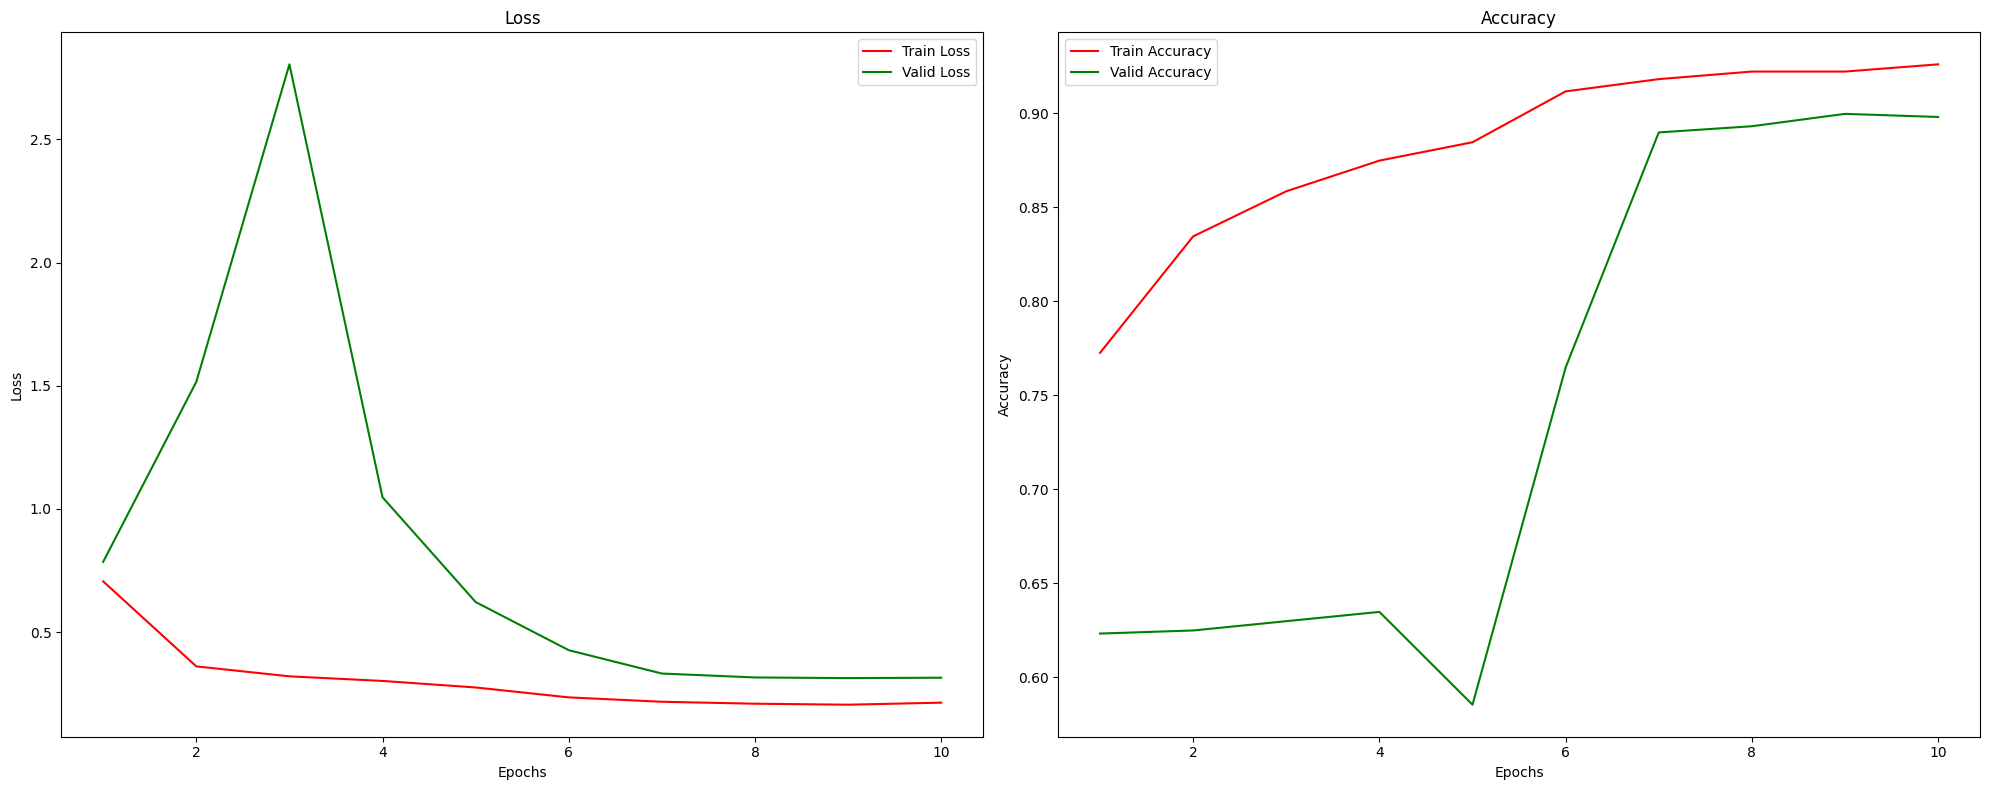

In [12]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

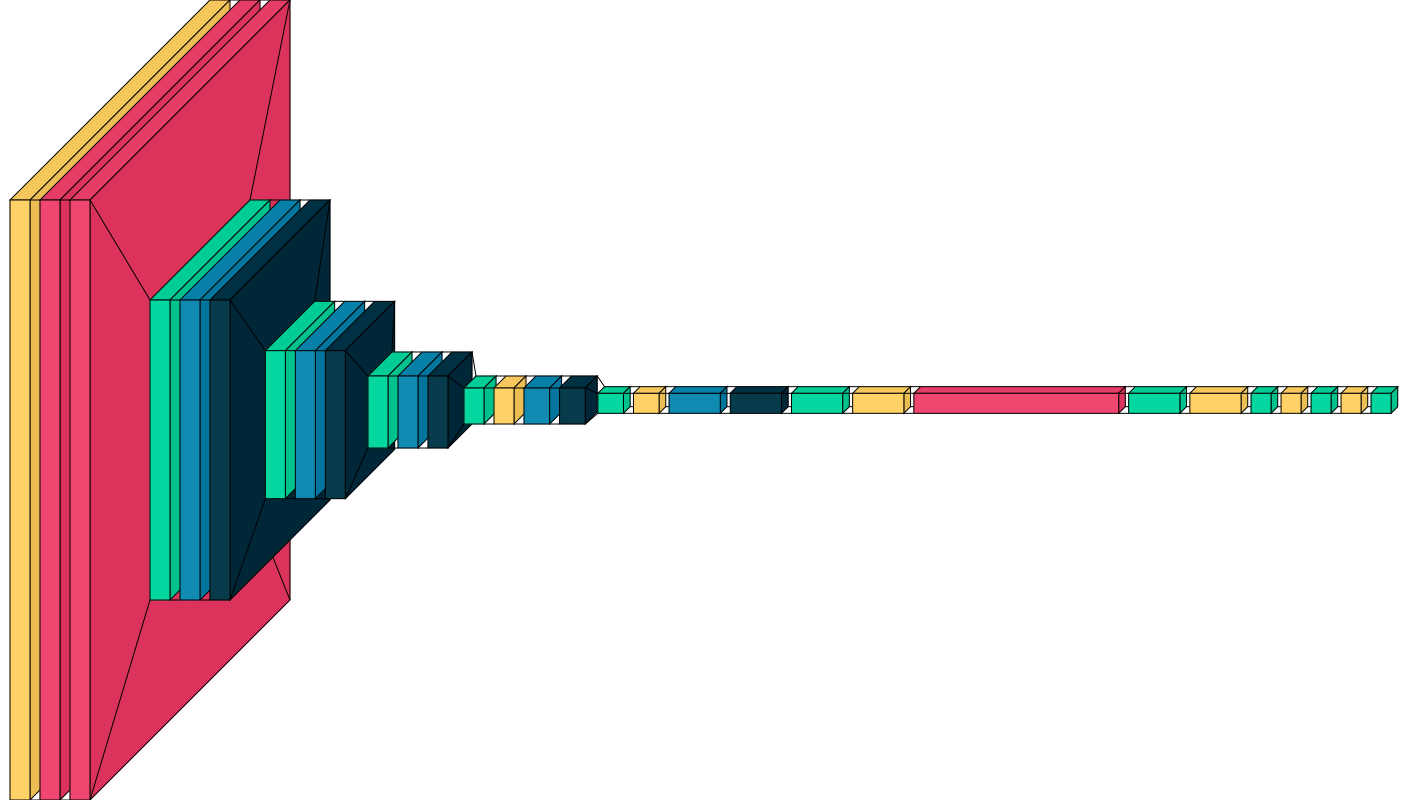

In [13]:
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [14]:
import netron
netron.start('C:/Users/nadon/Documents/MSC/UOP/Disser/MI/output.png')

Serving 'C:/Users/nadon/Documents/MSC/UOP/Disser/MI/output.png' at http://localhost:8080


('localhost', 8080)

In [15]:
model.save("C:/Users/nadon/Documents/MSC/UOP/Disser/MI")

INFO:tensorflow:Assets written to: C:/Users/nadon/Documents/MSC/UOP/Disser/MI\assets


INFO:tensorflow:Assets written to: C:/Users/nadon/Documents/MSC/UOP/Disser/MI\assets


In [16]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Process data
img_dims = 150
epochs = 10
batch_size  = 32

train_gen , test_gen , test_data , test_lables = process_data( img_dims , batch_size )


# Extract features using a pre-trained CNN
train_features = []
train_labels = []

test_features = []
test_labels = []

for i in range(len(train_gen)):
    batch_images, batch_labels = train_gen[i]
    features = model.predict(batch_images)
    train_features.extend(features)
    train_labels.extend(batch_labels)

for i in range(len(test_gen)):
    batch_images, batch_labels = test_gen[i]
    features = model.predict(batch_images)
    test_features.extend(features)
    test_labels.extend(batch_labels)

# Convert lists to numpy arrays
train_features = np.array(train_features)
test_features = np.array(test_features)
train_labels = np.array(train_labels).flatten()
test_labels = np.array(test_labels).flatten()

# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_features, train_labels)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(train_features, train_labels)

# Predictions
svm_predictions = svm_classifier.predict(test_features)
rf_predictions = rf_classifier.predict(test_features)

# Calculate accuracy
svm_accuracy = accuracy_score(test_labels, svm_predictions)
svm_f1 = f1_score(test_labels, svm_predictions)
svm_cf = confusion_matrix(test_labels, svm_predictions)
svm_report = classification_report(test_labels, svm_predictions)

rf_accuracy = accuracy_score(test_labels, rf_predictions)
rf_f1 = f1_score(test_labels, rf_predictions)
rf_cf = confusion_matrix(test_labels, rf_predictions)
rf_report = classification_report(test_labels, rf_predictions)

print("SVM Accuracy:", svm_accuracy)
print("SVM F1:", svm_f1)
print("SVM Confusion Matrix:", svm_cf)
print("SVM Report:", svm_report)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest F1:", rf_f1)
print("Random Forest Confusion Matrix:", rf_cf)
print("Random Forest Report:", rf_report)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
1/1 [==============================] - 0s 62ms/step
SVM Accuracy: 0.9006410256410257
SVM F1: 0.9236453201970444
SVM Confusion Matrix: [[187  47]
 [ 15 375]]
SVM Report:               precision    recall  f1-score   support

         0.0       0.93      0.80      0.86       234
         1.0       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624

Random Forest Accuracy: 0.8557692307692307
Random Forest F1: 0.8894348894348895
Random Forest Confusion Matrix: [[172  62]
 [ 28 362]]
Random Forest Report:               precision    recall  f1-score   support

         0.0       0.86      0.74      0.79       234
         1.0       0.85      0.93      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84   

C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nadon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in 

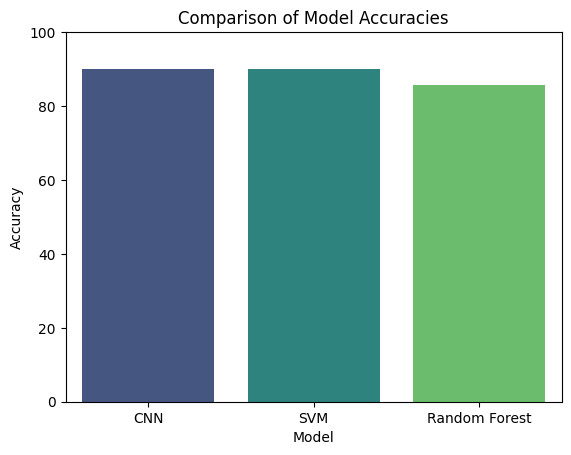

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
acc_list = [acc, svm_accuracy*100, rf_accuracy*100]
models = ['CNN', 'SVM', 'Random Forest']

# Create bar plot
sns.barplot(x=models, y=acc_list, palette='viridis')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 100)  # Adjust y-axis limit if needed
plt.show()

